# Initialization

## Define and Inport

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator, PercentFormatter
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import multiprocessing
from functools import partial
from pathlib import Path

In [2]:
from composite_factor import plot_factor_distributions, composite_factor_calculation, weighted_composite_factor, plot_quantile_backtests_log
from operations import ts_decay
from portfolio_simulation import SimulationSettings, Simulation
from factor_selector import FactorSelector, single_factor_metrics
from portfolio_analyzer import PortfolioAnalyzer
from multi_manager import run_multimanager_backtest

In [3]:
# Load data
features_df = pd.read_csv('data/2.symbol_features_long.csv')
features_df['date'] = pd.to_datetime(features_df['date'])
features_df.set_index(["date", "symbol"], inplace=True)

factors_df = pd.read_csv('data/8.factors_df.csv')
factors_df['date'] = pd.to_datetime(factors_df['date'])
factors_df.set_index(['date', 'symbol'], inplace=True)

single_factor_returns = pd.read_csv('data/9.single_factor_returns.csv')
single_factor_returns['date'] = pd.to_datetime(single_factor_returns['date'])
single_factor_returns.set_index(['date'], inplace=True)

In [4]:
# Define returns, cap_flag, investability_flag and pre-simulation settings
returns = features_df['log_return']
cap_flag = features_df['cap_flag']
investability_flag = features_df['investability_flag']
com_factors_df = pd.DataFrame(index=factors_df.index)

# Default SimSettings use equal_weight and transaction_cost = True
SimSettings = partial(
    SimulationSettings,
    returns=returns,
    cap_flag=cap_flag,
    investability_flag=investability_flag,
    factors_df=com_factors_df,
    method='equal',
    transaction_cost=True,
    max_weight=0.01,
    pct=0.1,
    min_universe=100,
    contributor=False,
    output_summary=False,
    output_returns=False,
    plot=True
)

In [5]:
def plot_decay_sensitivity(
    composite_factor: pd.Series,
    settings: SimulationSettings,
    decay_period: list[int] = [1, 3, 5, 10, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350],
    figsize: tuple[int, int] = (12, 6)
):
    """
    For each decay window d, re‐compute the factor via ts_decay, run the simulation,
    and plot annualized return (left axis) & Sharpe ratio (right axis) versus d.
    """
    annret_list = []
    sharpe_list = []
    settings.output_returns = True
    settings.plot = False
    for d in tqdm(decay_period, desc="Decay windows"):
        # decay the factor
        feat = ts_decay(composite_factor, d).rename("custom_feature")

        # run the simulation
        sim = Simulation(
            name=f"decay_{d}",
            custom_feature=feat,
            settings=settings,
        )
        result_df = sim.run()

        # extract the daily net returns
        daily_r = result_df["log_return"]

        # annualized return = (prod(1+r))^(252/N) - 1
        annret = (np.prod(1 + daily_r)) ** (252 / len(daily_r)) - 1
        # Sharpe ratio = mean(r)/std(r) * sqrt(252)
        sharpe = daily_r.mean() / daily_r.std() * np.sqrt(252)

        annret_list.append(annret)
        sharpe_list.append(sharpe)

    # plotting
    fig, ax1 = plt.subplots(figsize=figsize)

    # left axis: Annualized Return
    ax1.plot(decay_period, annret_list,
             marker='*', linestyle='-',
             label="Annualized Return")
    ax1.set_xlabel("Decay Window Length")
    ax1.set_ylabel("Annualized Return", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(decay_period)
    ax1.set_xlim(min(decay_period), max(decay_period))
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=6, prune='both'))
    ax1.yaxis.set_major_formatter(PercentFormatter(1.0))

    # right axis: Sharpe Ratio
    ax2 = ax1.twinx()
    ax2.plot(decay_period, sharpe_list,
             marker='o', linestyle='--',
             color='tab:orange', label="Sharpe Ratio")
    ax2.set_ylabel("Sharpe Ratio", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    plt.title("Annualized Return & Sharpe vs. Decay Window")
    plt.tight_layout()
    plt.show()

## Calculate Metrics

In [ ]:
# Calculate factor analysis metrics
factor_analysis_metrics = single_factor_metrics(factors_df, returns)
factor_analysis_metrics.to_csv('data/10.factor_analysis_metrics.csv')
plot_factor_distributions(factors_df, exclude=['log_return'], bins=40, ncols=6, figsize=(20, 4))
factor_analysis_metrics

# Full time Period

In [ ]:
# Prepare Full Sample Factor Selection
factor_analysis_metrics = pd.read_csv('data/10.factor_analysis_metrics.csv', index_col=0)
selected_factors = factor_analysis_metrics.index[factor_analysis_metrics['rank_IC_IR'] > -1].to_list()

### Zscore composite factor

In [ ]:
com_factor_zscore = composite_factor_calculation(factors_df, selected_factors, method='zscore')
settings_com_factor_z_eq = SimSettings()

In [ ]:
custom_feature = ts_decay(com_factor_zscore, 80).rename("custom_feature")
simulation_com_factor_z_eq_decay_80 = Simulation('com_factor_z_eq_decay_80', custom_feature, settings_com_factor_z_eq)
simulation_com_factor_z_eq_decay_80.run()

In [ ]:
# # Sensitivity with regard to decay window
# plot_decay_sensitivity(com_factor_zscore, settings_com_factor_z_eq)

### Rank composite factor

In [ ]:
com_factor_rank = composite_factor_calculation(factors_df, selected_factors, method='rank')
settings_com_factor_rank_flex = SimSettings(method='linear', plot=False, output_summary=True) # Update settings to linear method

In [ ]:
custom_feature = ts_decay(com_factor_rank, 150).rename("custom_feature")

simulation_com_factor_rank_flex_decay_150 = Simulation('com_factor_rank_flex_decay_150', custom_feature, settings_com_factor_rank_flex)
simulation_com_factor_rank_flex_decay_150.run()

In [ ]:
# # Sensitivity with regard to decay window
# plot_decay_sensitivity(com_factor_rank, settings_com_factor_rank_flex)

# Rolling Window Factor Selection

## Factor Selection

In [ ]:
print("=== Running ICIR-based factor selection ===")
factor_selector_icir = FactorSelector(
    factors_df=factors_df,
    returns=returns,
    factor_ret_df=single_factor_returns,
    window=60,
    method='icir_top',
    method_kwargs={'top_x': 5, 'icir_threshold': -1}
)

# Prepare factor selection
factor_weights_icir = factor_selector_icir.prepare_selection()
out_path = Path('data/factor_weights/factor_weights_icir.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)
factor_weights_icir.to_csv(out_path)
print(f"ICIR method average non-zero weights: {(factor_weights_icir > 0).sum(axis=1).mean():.2f}")
print(factor_weights_icir)

In [ ]:
print("=== Running Momentum-based factor selection ===")
factor_selector_momentum = FactorSelector(
    factors_df=factors_df,
    returns=returns,
    factor_ret_df=single_factor_returns,
    window=60,
    method='momentum',
    method_kwargs={
        'max_weight': 0.3,     # Maximum weight per factor
    }
)

# Prepare factor selection with Momentum
factor_weights_momentum = factor_selector_momentum.prepare_selection()

factor_weights_momentum.to_csv('data/factor_weights/factor_weights_momentum.csv')
print(f"Momentum method average non-zero weights: {(factor_weights_momentum > 0).sum(axis=1).mean():.2f}")
print(factor_weights_momentum)

In [ ]:
print("=== Running MVO-based factor selection with shrinkage ===")
factor_selector_mvo = FactorSelector(
    factors_df=factors_df,
    returns=returns,
    factor_ret_df=single_factor_returns,
    window=60,
    method='mvo',
    method_kwargs={
        'risk_aversion': 1.0,  # Trade-off between return and risk
        'max_weight': 0.3,     # Maximum weight per factor
        'turnover_penalty': 0.5,  # Penalty for weight changes (reduces turnover)
        'use_shrinkage': False  # Apply Ledoit-Wolf shrinkage to covariance matrix
    }
)

# Prepare factor selection with MVO and shrinkage
factor_weights_mvo = factor_selector_mvo.prepare_selection()
factor_weights_mvo.to_csv('data/factor_weights/factor_weights_mvo.csv')

print(f"MVO method average non-zero weights: {(factor_weights_mvo > 0).sum(axis=1).mean():.2f}")
print(factor_weights_mvo)

## Composite Factor Calculation

In [ ]:
factor_weights_icir = pd.read_csv('data/factor_weights/factor_weights_icir.csv')
factor_weights_icir['date'] = pd.to_datetime(factor_weights_icir['date'])
factor_weights_icir.set_index('date', inplace=True)

factor_weights_momentum = pd.read_csv('data/factor_weights/factor_weights_momentum.csv')
factor_weights_momentum['date'] = pd.to_datetime(factor_weights_momentum['date'])
factor_weights_momentum.set_index('date', inplace=True)

factor_weights_mvo = pd.read_csv('data/factor_weights/factor_weights_mvo.csv')
factor_weights_mvo['date'] = pd.to_datetime(factor_weights_mvo['date'])
factor_weights_mvo.set_index('date', inplace=True)

In [ ]:
composite_factor_icir_zscore = weighted_composite_factor(factors_df, factor_weights_icir, method='zscore')
composite_factor_momentum_zscore = weighted_composite_factor(factors_df, factor_weights_momentum, method='zscore')
composite_factor_mvo_zscore = weighted_composite_factor(factors_df, factor_weights_mvo, method='zscore')
composite_factor_icir_zscore.to_csv('data/composite_factors/composite_factor_icir_zscore.csv', index=True)
composite_factor_momentum_zscore.to_csv('data/composite_factors/composite_factor_momentum_zscore.csv', index=True)
composite_factor_mvo_zscore.to_csv('data/composite_factors/composite_factor_mvo_zscore.csv', index=True)

In [ ]:
# composite_factor_icir_rank = weighted_composite_factor(factors_df, factor_weights_icir, method='rank')
# composite_factor_momentum_rank = weighted_composite_factor(factors_df, factor_weights_momentum, method='rank')
# composite_factor_mvo_rank = weighted_composite_factor(factors_df, factor_weights_mvo, method='rank')
# composite_factor_icir_rank.to_csv('data/composite_factors/composite_factor_icir_rank.csv', index=True)
# composite_factor_momentum_rank.to_csv('data/composite_factors/composite_factor_momentum_rank.csv', index=True)
# composite_factor_mvo_rank.to_csv('data/composite_factors/composite_factor_mvo_rank.csv', index=True)

## Composite Factor Result

In [ ]:
# ICIR composite factor
composite_factor_icir_zscore = pd.read_csv('data/composite_factors/composite_factor_icir_zscore.csv',index_col=['date', 'symbol'],parse_dates=['date'])
composite_factor_icir_zscore = composite_factor_icir_zscore.squeeze()
custom_feature = ts_decay(composite_factor_icir_zscore, 150).rename("custom_feature").fillna(0)

settings_icir_composite_eq = SimSettings() 
simulation_icir_composite_eq = Simulation('com_factor_icir_eq', custom_feature, settings_icir_composite_eq)
simulation_icir_composite_eq.run()

settings_icir_composite_flexible = SimSettings(method='linear') 
simulation_icir_composite_flexible = Simulation('com_factor_icir_flexible', custom_feature, settings_icir_composite_flexible)
simulation_icir_composite_flexible.run()

settings_icir_composite_mvo = SimSettings(method='mvo') 
simulation_icir_composite_mvo = Simulation('com_factor_icir_mvo', custom_feature, settings_icir_composite_mvo)
simulation_icir_composite_mvo.run()

In [ ]:
# Momentum composite factor
composite_factor_momentum_zscore = pd.read_csv('data/composite_factors/composite_factor_momentum_zscore.csv',index_col=['date', 'symbol'],parse_dates=['date'])
composite_factor_momentum_zscore = composite_factor_momentum_zscore.squeeze()
custom_feature = ts_decay(composite_factor_momentum_zscore, 150).rename("custom_feature").fillna(0)

settings_momentum_composite_eq = SimSettings() 
simulation_momentum_composite_eq = Simulation('com_factor_momentum_eq', custom_feature, settings_momentum_composite_eq)
simulation_momentum_composite_eq.run()

settings_momentum_composite_flexible = SimSettings(method='linear') 
simulation_momentum_composite_flexible = Simulation('com_factor_momentum_flexible', custom_feature, settings_momentum_composite_flexible)
simulation_momentum_composite_flexible.run()

settings_momentum_composite_mvo = SimSettings(method='mvo') 
simulation_momentum_composite_mvo = Simulation('com_factor_momentum_mvo', custom_feature, settings_momentum_composite_mvo)
simulation_momentum_composite_mvo.run()

In [ ]:
# MVO composite factor
composite_factor_mvo_zscore = pd.read_csv('data/composite_factors/composite_factor_mvo_zscore.csv',index_col=['date', 'symbol'],parse_dates=['date'])
composite_factor_mvo_zscore = composite_factor_mvo_zscore.squeeze()
custom_feature = ts_decay(composite_factor_mvo_zscore, 150).rename("custom_feature").fillna(0)

settings_mvo_composite_eq = SimSettings() 
simulation_mvo_composite_eq = Simulation('com_factor_mvo_eq', custom_feature, settings_mvo_composite_eq)
simulation_mvo_composite_eq.run()

settings_mvo_composite_flexible = SimSettings(method='linear') 
simulation_mvo_composite_flexible = Simulation('com_factor_mvo_flexible', custom_feature, settings_mvo_composite_flexible)
simulation_mvo_composite_flexible.run()

settings_mvo_composite_mvo = SimSettings(method='mvo') 
simulation_mvo_composite_mvo = Simulation('com_factor_mvo_mvo', custom_feature, settings_mvo_composite_mvo)
simulation_mvo_composite_mvo.run()

In [ ]:
com_factors_df.to_csv('data/com_factors_df.csv', index=True)
com_factors_df = pd.read_csv('data/com_factors_df.csv')
com_factors_df['date'] = pd.to_datetime(com_factors_df['date'])
com_factors_df = com_factors_df.set_index(["date", "symbol"])
plot_factor_distributions(com_factors_df, exclude=['log_return'], bins=40, ncols=4)

In [ ]:
# plot_quantile_backtests_log(com_factors_df=com_factors_df,returns=returns,n_groups=10,ncols=2)

In [ ]:
# plot_decay_sensitivity(composite_factor_mvo_zscore, settings_mvo_composite)

## Multi Manager

In [ ]:
# factor_weights_icir = pd.read_csv('data/factor_weights/factor_weights_icir.csv')
# factor_weights_icir['date'] = pd.to_datetime(factor_weights_icir['date'])
# factor_weights_icir.set_index('date', inplace=True)

# factor_weights_momentum = pd.read_csv('data/factor_weights/factor_weights_momentum.csv')
# factor_weights_momentum['date'] = pd.to_datetime(factor_weights_momentum['date'])
# factor_weights_momentum.set_index('date', inplace=True)

# factor_weights_mvo = pd.read_csv('data/factor_weights/factor_weights_mvo.csv')
# factor_weights_mvo['date'] = pd.to_datetime(factor_weights_mvo['date'])
# factor_weights_mvo.set_index('date', inplace=True)

In [ ]:
# settings_icir_multimanager = SimSettings()

# multi_manager_icir, top_longs_icir, top_shorts_icir, counts_icir = run_multimanager_backtest(factors_df, returns, cap_flag, factor_weights_icir, settings_icir_multimanager)
# analysis_icir = PortfolioAnalyzer(multi_manager_icir)
# analysis_icir.plot_full_performance(counts_df=counts_icir)

In [ ]:
# settings_momentum_multimanager = SimSettings()

# multi_manager_momentum, top_longs_momentum, top_shorts_momentum, counts_momentum = run_multimanager_backtest(factors_df, returns, cap_flag, factor_weights_momentum, settings_momentum_multimanager)
# analysis_momentum = PortfolioAnalyzer(multi_manager_momentum)
# analysis_momentum.plot_full_performance(counts_df=counts_momentum)

In [ ]:
# settings_mvo_multimanager = SimSettings()

# multi_manager_mvo, top_longs_mvo, top_shorts_mvo, counts_mvo = run_multimanager_backtest(factors_df, returns, cap_flag, factor_weights_mvo, settings_mvo_multimanager)
# analysis_mvo = PortfolioAnalyzer(multi_manager_mvo)
# analysis_mvo.plot_full_performance(counts_df=counts_mvo)

## Test

MVO optimization: 100%|██████████| 1332/1332 [11:46<00:00,  1.88it/s]


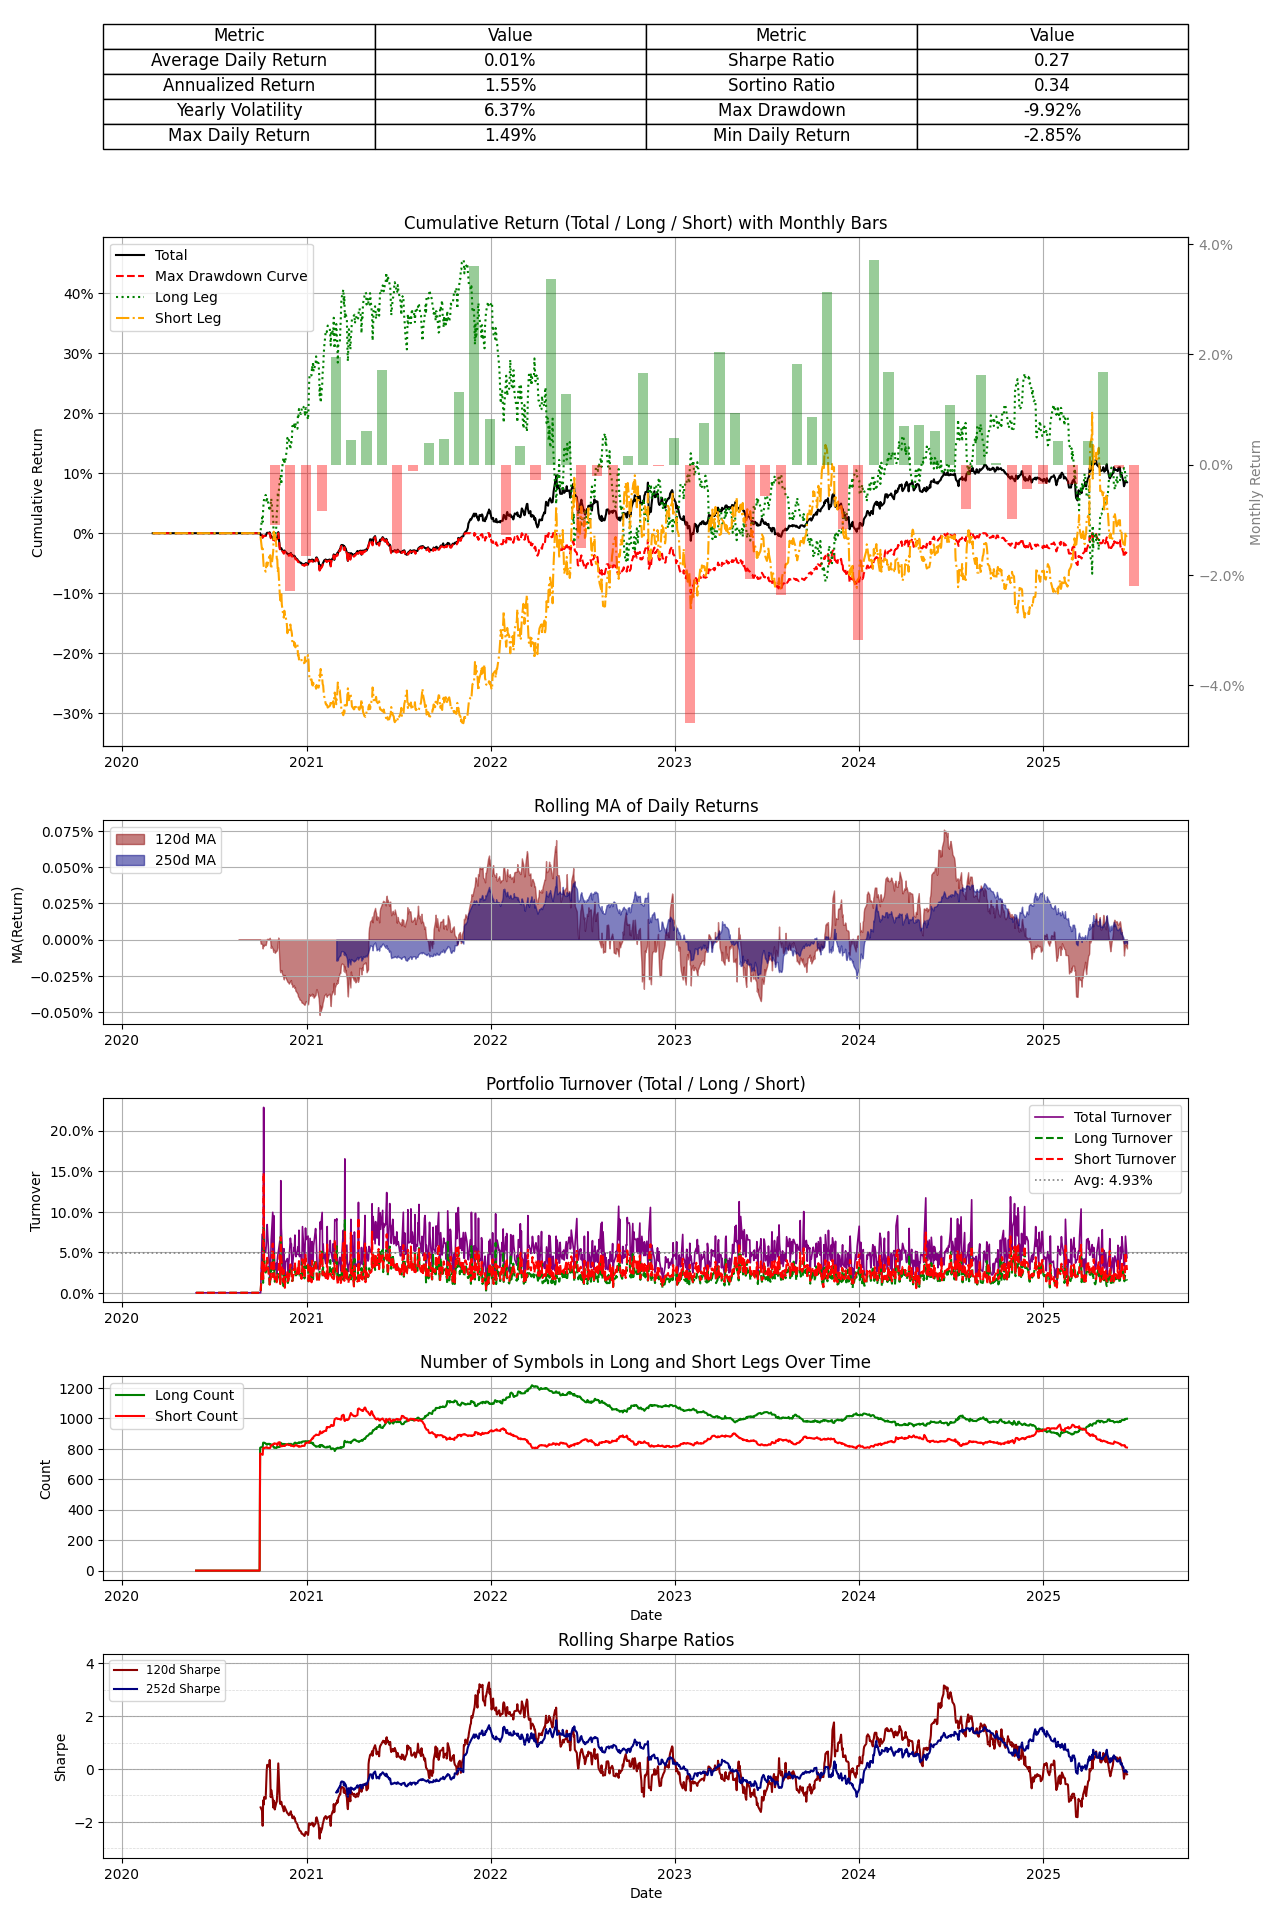

In [6]:
composite_factor_icir_zscore = pd.read_csv('data/composite_factors/composite_factor_icir_zscore.csv',index_col=['date', 'symbol'],parse_dates=['date'])
composite_factor_icir_zscore = composite_factor_icir_zscore.squeeze()
custom_feature = ts_decay(composite_factor_icir_zscore, 150).rename("custom_feature").fillna(0)

settings_icir_composite_mvo = SimSettings(method='mvo') 
simulation_icir_composite_mvo = Simulation('com_factor_icir_mvo', custom_feature, settings_icir_composite_mvo)
simulation_icir_composite_mvo.run()